# Importing the required libraries

In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchvision import transforms as T
from albumentations.pytorch import ToTensorV2
from glob import glob
import albumentations as A
from tqdm import tqdm
from PIL import Image
import numpy as np
from PIL import Image
import pandas as pd
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




# 2. Initializing the required parameters, creating transforms, creating train, valid, and test data loaders.

In [50]:
Img_size = 75  
num_epochs = 30
learning_rate = 0.01
batch_size = 7
pin_memory = True
num_workers = 2

class Transforms:
    def __init__(self):
        self.transforms = A.Compose(
    [
        A.Resize(Img_size, Img_size),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # A.dropout.cutout.Cutout(),
        Otsu(),
        ToTensorV2()
    ]
)

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img, np.float32))['image']

transforms = T.Compose([T.ToTensor(), T.Resize([Img_size, Img_size]), T.GaussianBlur(3), Otsu])



class Testdata(Dataset):
    def __init__(self, directory, transforms):
        self.files = glob(directory)
        self.transform = transforms
        self.dir = directory
    def __len__(self):
        return len(self.files)
    def __getitem__(self, index):
        file = self.files[index]
        img = Image.open(file).convert('RGB')
        img = self.transform(img)
        return img, file

full_dataset = ImageFolder(r"/content/drive/MyDrive/SCTL-main/SCTL-main/Train", transform = transforms)
test_ds = Testdata("/content/drive/MyDrive/SCTL-main/SCTL-main/Test/Test/*.jpg", transforms= transforms)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_dl = DataLoader(train_dataset, batch_size=batch_size, pin_memory=pin_memory, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=pin_memory, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, pin_memory=pin_memory)

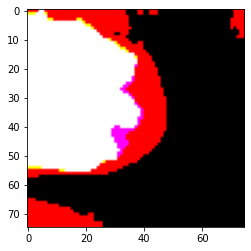

In [52]:
for img, lbl in train_dl:
  plt.imshow(img[0].swapaxes(0, 2))
  img = img[0].numpy()
  # print(img[0].shape)
  break

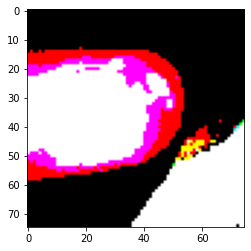

In [47]:
# Implementing OTSU's thresholding
# img = img.flatten()
# plt.hist(img)
def Otsu(img):
  mean = img.mean()
  img[img > mean] = 1
  img[img < mean ] = 0
  return img  
img = Otsu(img)
plt.imshow(img)

# 3. Creating and training the model

In [55]:
class TeatClassifier(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(3*75*75, 15000), 
            nn.LeakyReLU(),
            nn.Linear(15000, 5000),
            nn.LeakyReLU(),
            nn.Linear(5000, 1000),
            nn.LeakyReLU(), 
            nn.Linear(1000, 4),
            nn.Softmax()
        )

    def forward(self, x): 
        return self.model(x)

device = "cuda" if torch.cuda.is_available() else "cpu"

clf = TeatClassifier().to(device)
clf

TeatClassifier(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16875, out_features=15000, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=15000, out_features=5000, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=5000, out_features=1000, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=1000, out_features=4, bias=True)
    (8): Softmax(dim=None)
  )
)

In [56]:
optim = torch.optim.Adam(clf.parameters(), lr=learning_rate, weight_decay=0.3)
criterion = nn.CrossEntropyLoss(label_smoothing=0.3) 
train_loss = []
valid_loss = []
valid_acc = []
train_acc = []


for epoch in range(num_epochs):
# Training loop
    correct = 0
    for batch in train_dl: 
        X,y = batch 
        X, y = X.to(device), y.to(device) 
        yhat = clf(X) 
        loss = criterion(yhat, y) 
        # Apply backprop 
        optim.zero_grad()
        loss.backward() 
        optim.step() 
        correct += (torch.argmax(yhat, dim=1) == y).float().sum().detach().cpu()
    accuracy = 100 * correct / len(train_dataset)
    train_acc.append(accuracy)    
    # print(f"Epoch:{epoch} training accuracy is {accuracy}")
    train_loss.append(loss.item())
    # print(f"Epoch:{epoch} training loss is {loss.item()}")
    
    clf.eval()

# Valid loop
    correct = 0
    for batch in valid_dl:
        X, y = batch 
        X, y = X.to(device), y.to(device) 
        yhat = clf(X) 
        loss = criterion(yhat, y)
        correct += (torch.argmax(yhat, dim=1) == y).float().sum().detach().cpu()
    accuracy = 100 * correct / len(valid_dataset)
    valid_acc.append(accuracy)
    # print(f"Epoch:{epoch} valid accuracy is {accuracy}") 
    # print(f"Epoch:{epoch} valid loss is {loss.item()}")
    valid_loss.append(loss.item())

    # if epoch%5 == 0:
    print(f"Epoch:{epoch} training accuracy is {train_acc[-1] }")
    print(f"Epoch:{epoch} training loss is {train_loss[-1]}")
    print(f"Epoch:{epoch} valid accuracy is {valid_acc[-1]}")
    print(f"Epoch:{epoch} valid loss is {valid_loss[-1]}")

Epoch:0 training accuracy is 39.60826873779297
Epoch:0 training loss is 1.3847947120666504
Epoch:0 valid accuracy is 45.21739196777344
Epoch:0 valid loss is 1.3822938203811646
Epoch:1 training accuracy is 42.002174377441406
Epoch:1 training loss is 1.3704687356948853
Epoch:1 valid accuracy is 45.21739196777344
Epoch:1 valid loss is 1.3763614892959595
Epoch:2 training accuracy is 40.80522155761719
Epoch:2 training loss is 1.3851449489593506
Epoch:2 valid accuracy is 35.21739196777344
Epoch:2 valid loss is 1.381089210510254
Epoch:3 training accuracy is 37.21436309814453
Epoch:3 training loss is 1.3701411485671997
Epoch:3 valid accuracy is 45.21739196777344
Epoch:3 valid loss is 1.3821622133255005
Epoch:4 training accuracy is 41.89336395263672
Epoch:4 training loss is 1.3925985097885132
Epoch:4 valid accuracy is 35.21739196777344
Epoch:4 valid loss is 1.3772224187850952
Epoch:5 training accuracy is 42.981502532958984
Epoch:5 training loss is 1.374381422996521
Epoch:5 valid accuracy is 45.

KeyboardInterrupt: ignored

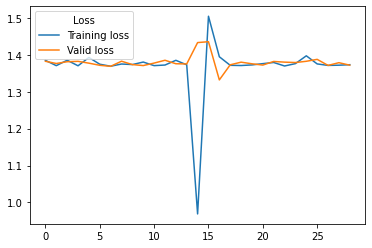

In [58]:
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend(loc='upper left', title='Loss');

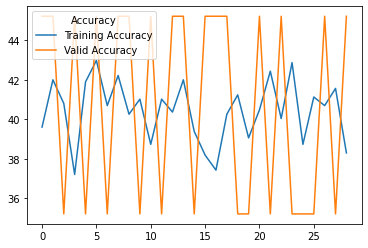

In [59]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Valid Accuracy')
plt.legend(loc='upper left', title='Accuracy');

# Saving the model, loading it and making predictions

In [60]:
with open('model_state.pt', 'wb') as f: 
    torch.save(clf.state_dict(), f) 

with open('model_state.pt', 'rb') as f: 
    clf.load_state_dict(torch.load(f))

test_preds = []
files = []

for batch in test_dl:
    img, fname = batch
    pred = clf(img.to(device))
    test_preds.extend(torch.argmax(pred, dim=1).detach().cpu())
    files.extend(np.array(fname).flatten())

df = pd.DataFrame({"Imagename":files, "preds":test_preds})
df.preds = df.preds.astype(int)
df.Imagename = df.Imagename.apply(lambda x: x.split("/")[-1])
df.to_csv("submission.csv", header=None, index=None)
pd.read_csv("submission.csv")

380
380


,20200724_094356_LH_C2_PN_M.jpg,1
0,20200724_094157_LF_C2_PN_M.jpg,1
1,20200724_094108_RF_C1_PN_M.jpg,1
2,20200724_093930_LH_C3_PN_M.jpg,1
3,20200724_094337_RF_C1_PN_M.jpg,1
4,20200724_094337_LH_C1_PN_M.jpg,1
...,...,...
374,R8_0736_45_crop_RF_C4_PN_m.jpg,1
375,R8_0726_35_crop_LH_C2_PN_m.jpg,1
376,R7_0692_48_crop_LH_C2_PN_m.jpg,1
377,R9_0793_57_crop_LH_C2_PP_m.jpg,1


#### Test accuracy

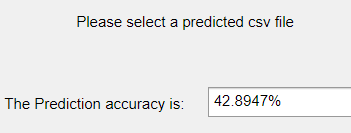